In [1]:
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
plt.style.use('seaborn')
start = time.time()

In [2]:
with open ('training/labels.tsv', 'r') as f:
    txt = f.read()

In [3]:
range_of_posts = re.findall('[0-9]{6}', txt)


In [4]:
post_filenames = ["training/posts/post-{}.xml".format(id) for id in range_of_posts]

In [5]:
def return_elements(filename):
    # get board name
    with open(filename, 'r') as f:
        txt = f.read()
    soup = BeautifulSoup(txt, 'lxml')
    message = soup.message
    board_id = message.board_id.text
    post_time = message.post_time.text
    subject = message.subject.text
    post_id = message.id.text
    author_id = message.author.get('href').split('/')[-1]
    root_id = message.root.get('href').split('/')[-1]
    body_text, emoji_ids = parse_body(message) # what to get out of body
    d = {}
#     d[author_id] = 
    return [author_id, board_id, post_time, subject, post_id, root_id, body_text, emoji_ids]

def parse_body(message):
    counter = 0
    for content in message.contents:
        if content.name == 'last_edit_time':
            break
        counter += 1
    body = message.contents[counter+1]
    body_text = re.findall("[a-zA-Z0-9]+(?![^<]*\>)", body.string)
    body_text = list(filter(lambda a: a != 'nbsp', body_text))
    emojis = re.findall('id="[a-z]+"', body.string)
    emoji_ids = [emoji.split('"')[1] for emoji in emojis]
    if len(emoji_ids) == 0:
        emoji_ids = None
    return body_text, emoji_ids
        

In [6]:
list_of_parsings = [return_elements(filename) for filename in post_filenames]

In [7]:
df = pd.DataFrame(list_of_parsings)
df.columns = ['author_id', 'board_id', 'post_time', 'subject', 'post_id', 'root_id', 'body_text', 'emoji_ids']

# Y if the message is a response, N if it is an original post
df["reply_or_not"] = df['subject'].apply(lambda x: "Y" if "Re:" in x else "N")

# this is so we can have an accumulator of posts over a week or an hour
df["post"] = 1

In [8]:
# get labels to merge to features
labs = pd.read_csv("training/labels.tsv", sep='\t',names=["post_id", "color_label", "micro_label"])
df.post_id = pd.to_numeric(df.post_id)
merged = pd.merge(df, labs, on='post_id')

# set time of post as the index
merged = merged.set_index(pd.DatetimeIndex(merged['post_time']))


In [9]:
merged.head()
end = time.time()
# merged.to_csv('training_df.csv')
print('{} seconds have passsed'.format((end-start)))

3.503560781478882 seconds have passsed


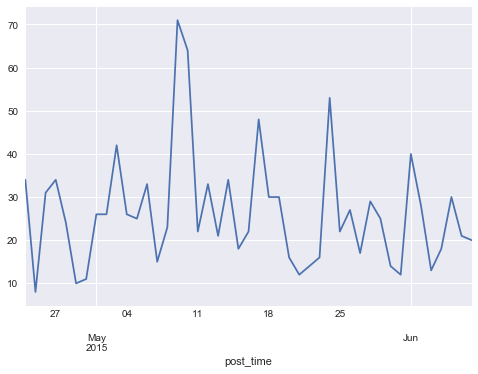

In [10]:
# how often peple post per day
merged.post.resample("D").sum().plot();

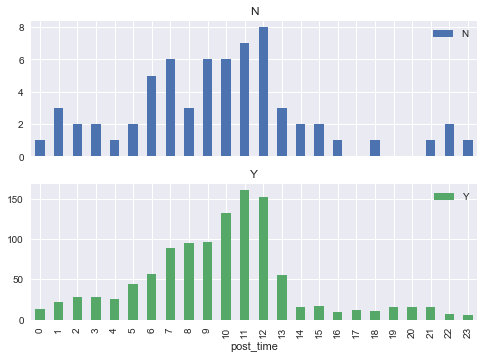

In [11]:
# Hours posts split by whether it was a reply or an original post
merged.groupby([merged.index.hour,'reply_or_not']).post.agg('sum').unstack(1).plot(kind='bar', subplots=True);

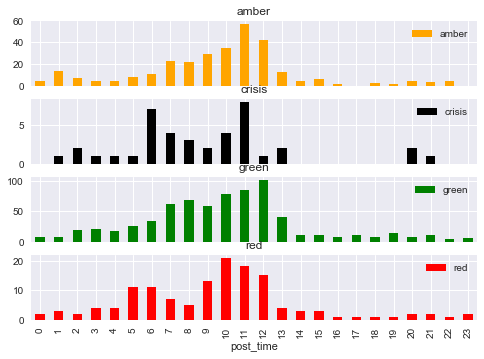

In [12]:
# Hours posts split by whether it was a reply or an original post

merged.groupby([merged.index.hour,'color_label']).post.agg('sum').unstack(1).plot(kind='bar', subplots=True, 
                                                                                  color = ['orange', 'black', 'green', 'red']);

Based on the plot above, the following cutoffs will be used:
- morning: 5-11
- afternoon: 12-17
- night: 18-4

In [13]:
# proportion of original replies vs not
print(Counter(merged.reply_or_not))
print('\n')
# color label by first post or reply. It matches the intuition that many non threatening posts are replies
# and more original posts tend to be red or crisis
print(merged.groupby(["color_label", "reply_or_not"]).size())

Counter({'Y': 1123, 'N': 65})


color_label  reply_or_not
amber        N                11
             Y               285
crisis       N                 8
             Y                32
green        N                 7
             Y               708
red          N                39
             Y                98
dtype: int64


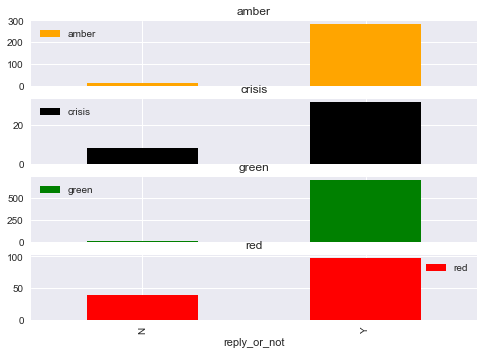

In [14]:
# color label by first post or reply. It matches the intuition that many non threatening posts are replies
# and more original posts tend to be red or crisis
merged.groupby(['reply_or_not','color_label']).post.agg('sum').unstack(1).plot(kind='bar', subplots=True,
                                                                               color = ['orange', 'black', 'green', 'red']);

## making sure the body is parsed correctly


In [15]:
# with open("training/posts/post-135294.xml") as f:
#     post = f.read()

In [16]:
# soup = BeautifulSoup(post, 'lxml')
# message = soup.message

In [17]:
# text = ' '.join(parse_body(message)[0])
# print(text)

In [18]:
# from wordcloud import WordCloud

In [19]:
# wordcloud = WordCloud().generate(text)

# # Display the generated image:
# # the matplotlib way:
# import matplotlib.pyplot as plt
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# # lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

In [20]:
# wc_list = []
# for txt in df.body_text[0:10]:
#     if len(' '.join(txt)) > 5:
#         wc_list.append(WordCloud(max_font_size=40).generate(' '.join(txt)))
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

In [21]:
# import time
# for wc in wc_list[0:10]:
#     plt.figure()
#     plt.imshow(wc, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()
#     time.sleep(1)
#     plt.close()

author_id       object
board_id        object
post_time       object
subject         object
post_id          int64
root_id         object
body_text       object
emoji_ids       object
reply_or_not    object
post             int64
dtype: object

author_id       object
board_id        object
post_time       object
subject         object
post_id          int64
root_id         object
body_text       object
emoji_ids       object
reply_or_not    object
post             int64
color_label     object
micro_label     object
dtype: object

{'amber', 'crisis', 'green', 'red'}